Following the tutorial in http://www.marcosantoni.com/2016/05/15/bayesian-ab-testing-in-python.html

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from pymc import Uniform, rbernoulli, Bernoulli, MCMC, deterministic

We want to model

$$
P(\text{click}|\text{page} = A) = \left\{ 
\begin{aligned}
& p_A && \text{click} = 1 \\
& 1 - p_A && \text{click} = 0
\end{aligned}
\right.
$$

Here we simulate some occurrences of users clicking on "buy" in page A

In [2]:
p_A_true = 0.05 # this is unknown (what we want to find)
N = 1500
occurrences = rbernoulli(p_A_true, N)

print('Click-BUY', occurrences.sum())
print('Observed frequency', occurrences.sum() / float(N))

('Click-BUY', 64)
('Observed frequency', 0.042666666666666665)


Now we define a prior on $p_A$.
This is the first step and is our prior belief in the variable.

In [3]:
# an uniform distribution
p_A = Uniform('p_A', lower=0, upper=1)

# the observations of the click events
obs = Bernoulli('obs', p_A, value=occurrences, observed=True)

Now we simulate using Monte Carlo simulations to fit the data
to the prior belief.

In [4]:
mcmc = MCMC([p_A, obs]) # Monte Carlo Markov Chain

mcmc.sample(20000, 1000) 

print(mcmc.trace('p_A')[:]) # posterior

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec[0.04191058 0.04191058 0.04191058 ... 0.03801481 0.03801481 0.03801481]


/home/julio/miniconda3/envs/science/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


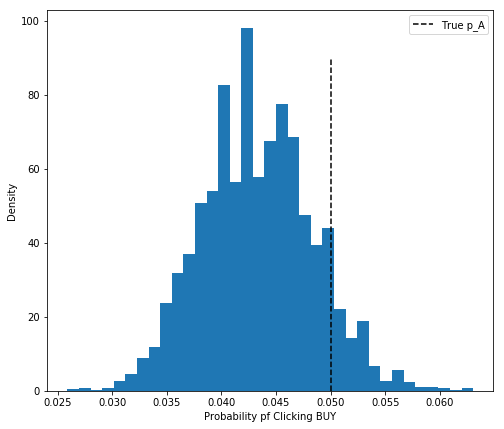

In [5]:
plt.figure(figsize=(8, 7))
plt.hist(mcmc.trace('p_A')[:], bins=35, histtype='stepfilled', normed=True)
plt.xlabel('Probability pf Clicking BUY')
plt.ylabel('Density')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A')
plt.legend()
plt.show()

What if we want to know the 90% confidence interval for $p_A$?

In [6]:
p_A_samples = mcmc.trace('p_A')[:]
lower_bound = np.percentile(p_A_samples, 5)
upper_bound = np.percentile(p_A_samples, 95)
print('There is 90%% probability that p_A is between %s and %s' % (lower_bound, upper_bound))

There is 90% probability that p_A is between 0.03532761508751441 and 0.05185333909621951


Comparing $p_A$ and $p_B$

('Observed frequency A ', 0.058)
('Observed frequency B ', 0.03333333333333333)
 [-----------------100%-----------------] 25000 of 25000 complete in 3.3 sec

/home/julio/miniconda3/envs/science/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/julio/miniconda3/envs/science/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/julio/miniconda3/envs/science/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'p_A - p_B')

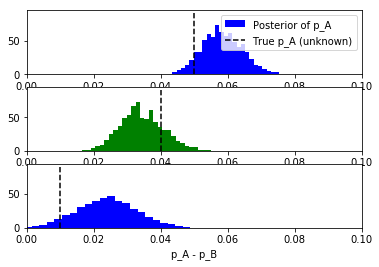

In [7]:
p_A_true = 0.05
p_B_true = 0.04
N_A = 1500
N_B = 750

occurrences_A = rbernoulli(p_A_true, N_A)
occurrences_B = rbernoulli(p_B_true, N_B)

print('Observed frequency A ', occurrences_A.sum() / float(N_A))
print('Observed frequency B ', occurrences_B.sum() / float(N_B))

p_A = Uniform('p_A', lower=0, upper=1)
p_B = Uniform('p_B', lower=0, upper=1)

@deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

obs_A = Bernoulli('obs_A', p_A, value=occurrences_A, observed=True)
obs_B = Bernoulli('obs_B', p_B, value=occurrences_B, observed=True)

mcmc = MCMC([p_A, p_B, obs_A, obs_B, delta])
mcmc.sample(25000, 5000)

p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

plt.subplot(3, 1, 1)
plt.xlim(0, 0.1)
plt.hist(p_A_samples, bins=35, histtype='stepfilled', normed=True, color='blue', label='Posterior of p_A')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A (unknown)')
plt.xlabel('Probability of clicking BUY via A')
plt.legend()

plt.subplot(3, 1, 2)
plt.xlim(0, 0.1)
plt.hist(p_B_samples, bins=35, histtype='stepfilled', normed=True, color='green', label='Posterior of p_A')
plt.vlines(p_B_true, 0, 90, linestyle='--', label='True p_B (unknown)')
plt.xlabel('Probability of clicking BUY via B')

plt.subplot(3, 1, 3)
plt.xlim(0, 0.1)
plt.hist(delta_samples, bins=35, histtype='stepfilled', normed=True, color='blue', label='Posterior of delta')
plt.vlines(p_A_true - p_B_true, 0, 90, linestyle='--', label='True delta (unknown)')
plt.xlabel('p_A - p_B')